# Notebook To Compare Results By Training Loss Function 

# Step 0 Set up Notebook

In [1]:
# import needed libaries
import os
import boto3
import mlflow
import time
from PIL import Image
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from snowML.viz import download_metrics as dm
from snowML.datapipe import snow_types as st
from snowML.datapipe import get_geos as gg
from snowML.datapipe import data_utils as du
from snowML.datapipe import get_dem as gd

In [2]:
# initialize erathengine credentials
import ee
ee.Authenticate()

True

In [3]:
import importlib
importlib.reload(dm)

<module 'snowML.viz.download_metrics' from '/home/suetboyd/Capstone/SnowML/src/snowML/viz/download_metrics.py'>

# Step1 - Get ML Flow Metrics

In [4]:
# create a dictionary of run_ids 
run_dict = dm.create_run_dict_Ex5()
print(run_dict)

{'Maritime_DI_low_batch': 'd8e9971eb89f4ce087fddb766aa85ef1', 'Maritime_DI_mse': '5d8480525f5246f3a9cad0948daf9fde', 'Maritime_DI_mae': 'c11ded8d42c24b5aa23746e8c7eb0121', 'Maritime_DI_hybrid': 'be0e7e4963a94309b7447ceb70ee8bb2', 'Ephemeral_DI_hybrid': 'ec1bc8b9064841cba401607a5c3866bc', 'Ephemeral_DI_mse': 'd462d25d0aac4ae1952e502ee435ccd0', 'Maritime_DI_MSE': 'f56504d6c33447c095615c2167d9b5d2'}


In [5]:
# create a dictionary of dataframes corresponding to the run_id shortname uploading from local files 
# Assumes you have already run the "download metrics" script from the snowML.Scripts package to save the metrics to local files
df_dict = {}
for key in run_dict.keys(): 
    run_id = run_dict[key]
    file = f"../../mlflow_data/run_id_data/metrics_from_{run_id}.csv"
    df_metrics = pd.read_csv(file)
    #print(df_metrics.shape)
    df_dict[key] = df_metrics

In [6]:
# display example
df_metrics = df_dict["Maritime_DI_mse"]
df_metrics.head(2)

,Metric,Step,Value
0,test_mse_170200090106,0,0.005901
1,test_mse_170200090106,1,0.005364


# Step 2 - Functions To Summarize Metrics

In [7]:
# function to extract only a specific metric by suffix
def extract_metric_by_suffix(df, metric_name, step = False):
    """Extracts rows where the Metric column ends with 'metric_name' and returns only Metric, Valuem and optionally Step columns."""
    if step: 
        return df[df['Metric'].str.endswith(metric_name)][['Metric', "Step",'Value']].sort_values(by='Metric')
    else: 
        return df[df['Metric'].str.endswith(metric_name)][['Metric', 'Value']].sort_values(by='Metric')

In [8]:
# function to extract only a specific metric by prefix
def extract_metric_by_prefix(df, prefix, step=False):
    """Extracts rows where the Metric column begins with 'prefix' and returns only Metric, Value and optionally step columns."""
    if step:
        return df[df['Metric'].str.startswith(prefix)][['Metric', "Step", 'Value']].sort_values(by='Metric')
    else:
        return df[df['Metric'].str.startswith(prefix)][['Metric', 'Value']].sort_values(by='Metric')

# Step 3 Define Some Plotting Functions

In [9]:
def plot_step_metrics(df, title='Metrics vs Step', save = True):
    """Plots all columns in the given DataFrame against the index with a legend."""
    
    plt.figure(figsize=(10, 5))
    
    # Plot each column
    for column in df.columns:
        plt.plot(df.index, df[column], marker='o', linestyle='-', label=column)
    
    # Labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    
    if save: 
        plt.savefig(f"charts/ModelChoice/{title}.png", bbox_inches='tight')
    
    plt.show()

In [10]:
def plot_median_comparison(df_dict, title="Median_Metric_Comparison_By_Epoch_And_Run", save = True):
    """Plots the 'median' column against the index for each DataFrame in the dictionary."""
    
    plt.figure(figsize=(10, 5))
    
    # Plot each DataFrame
    for label, df in df_dict.items():
        plt.plot(df.index, df['median'], marker='o', linestyle='-', label=label)
    
    # Labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Median Value')
    plt.title(title)
    #plt.ylim(-1, 1)  # Set fixed y-axis range
    plt.legend()
    plt.grid(True)
    
    if save: 
        plt.savefig(f"charts/ModelChoice/{title}.png", bbox_inches='tight')

    plt.show()

In [11]:
def plot_median_comparison_2(dict_all, eval_metric, save = True):
    """Plots the 'median' column against the index for each DataFrame in the dictionary."""

    filtered_dict = {k: v for k, v in dict_all.items() if v.get('eval_metric') == eval_metric}
    title = f"Median_{eval_metric}_by_Epoch_and_run"
    
    plot_dict = {}
    for k, v in filtered_dict.items(): 
        df = v.get('df')
        plot_dict[k] = df
        
    plt.figure(figsize=(10, 5))
    
    # Plot each DataFrame
    for label, df in plot_dict.items():
        cleaned_label = re.sub(r'_eval_.*$', '', label)
        plt.plot(df.index, df['median'], marker='o', linestyle='-', label=cleaned_label)
    
    # Labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Median Value')
    plt.title(title)
    #plt.ylim(-1, 1)  # Set fixed y-axis range
    plt.legend()
    plt.grid(True)
    
    if save: 
        plt.savefig(f"charts/{title}.png", bbox_inches='tight')

    plt.show()

# Step 4 - Extract Statistics for an Example Run

In [12]:
def extract_metric_summary(run_name, metric_name):
    df_metrics = df_dict[run_name]
    df_filtered = extract_metric_by_prefix(df_metrics, metric_name, step=True)
    summary = df_filtered.groupby("Step")["Value"].agg(["median", "mean", "min", "max", "std"])
    return summary

In [13]:
#run_name = "Maritime_DI_mse"
run_name = "Maritime_DI_mse"
metric_name = "test_kge"


In [14]:
summary = extract_metric_summary(run_name, metric_name)
print(f"For run {run_name}, summary stats for {metric_name} is")
summary.head(2)

For run Maritime_DI_mse, summary stats for test_kge is


,median,mean,min,max,std
Step,,,,,
0,0.939295,0.917847,-0.604816,0.989414,0.134599
1,0.939659,0.926308,0.611331,0.992280,0.054565


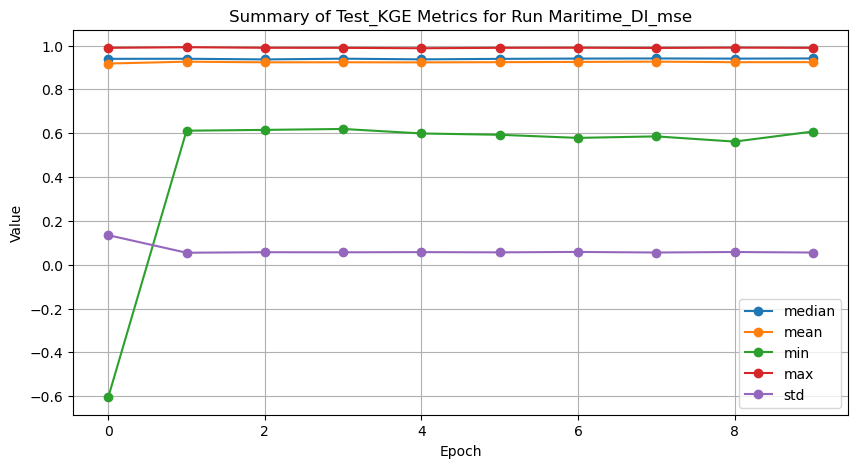

In [15]:
ttl = f"Summary of Test_KGE Metrics for Run {run_name}"
plot_step_metrics(summary, title = ttl, save = False)

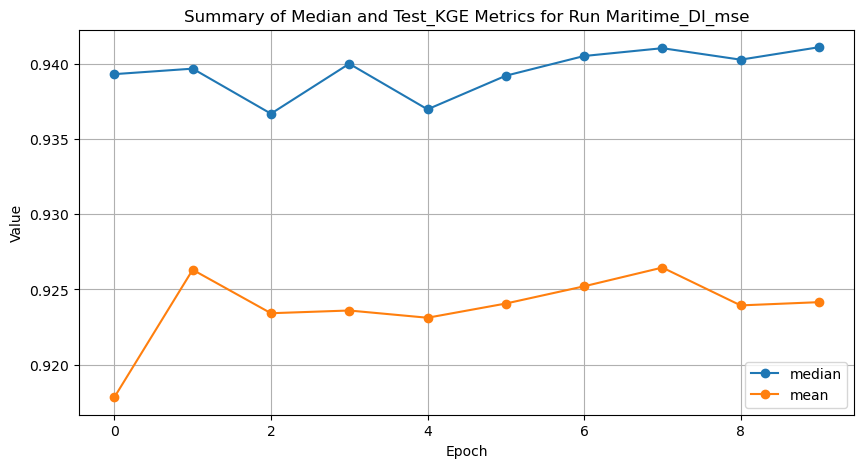

In [16]:
# zoom in on just the median and the mean
ttl = f"Summary of Median and Test_KGE Metrics for Run {run_name}" 
summary_slim = summary[["median", "mean"]]
plot_step_metrics(summary_slim, title = ttl, save = False)

In [17]:
# Step 5 - Plot Metric by epoch, for each run

In [18]:
def metric_summary_2(df_dict):
    metric_summary_dict = {}
    for key in df_dict.keys(): 
        for metric in ["kge", "mse", "mae", "r2"]:
            inner_dict = {}
            df_metric = df_dict[key]
            metric_name = f"test_{metric}"
            df_filtered = extract_metric_by_prefix(df_metric, metric_name, step=True)
            summary_df = df_filtered.groupby("Step")["Value"].agg(["median"])
            inner_dict["df"] = summary_df
            inner_dict["eval_metric"] = metric_name
            inner_dict["snow_type"] = key.split('_')[0]
            inner_dict["train_loss"] = key.split('_')[2]
            metric_summary_dict[f"{key}_eval_{metric}"] = inner_dict
    return metric_summary_dict

In [19]:
dict_all = metric_summary_2(df_dict)

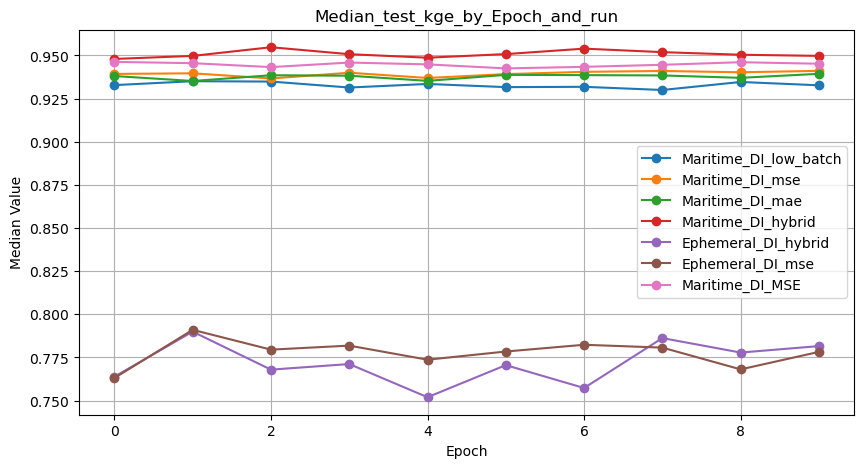

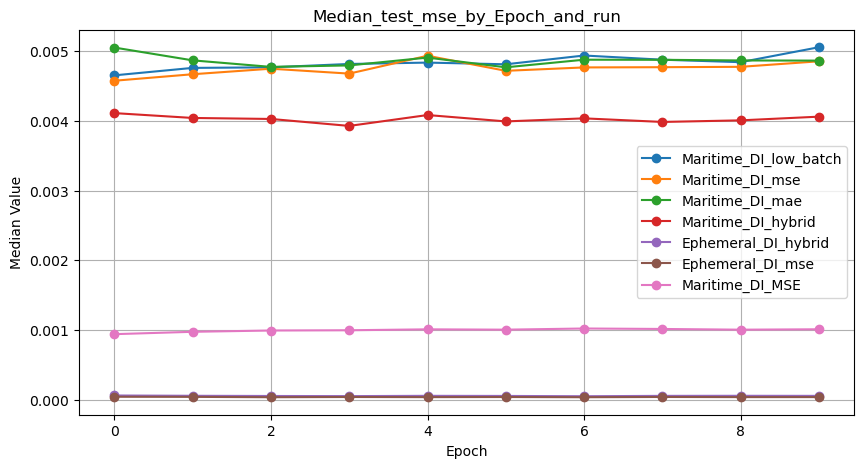

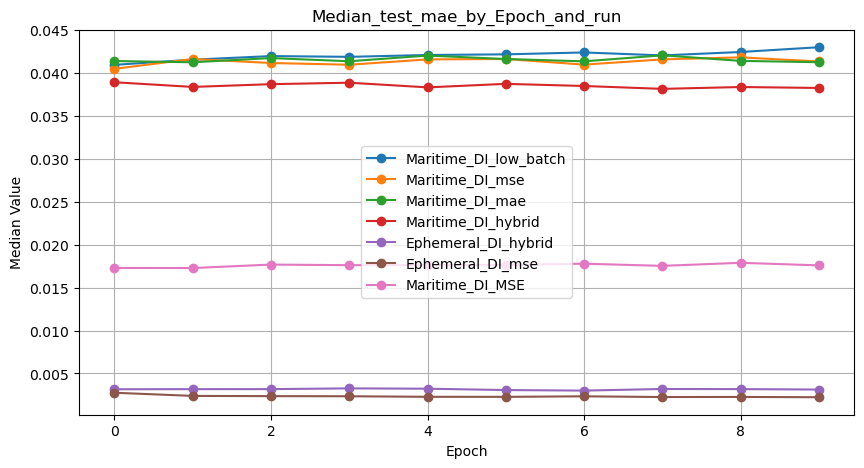

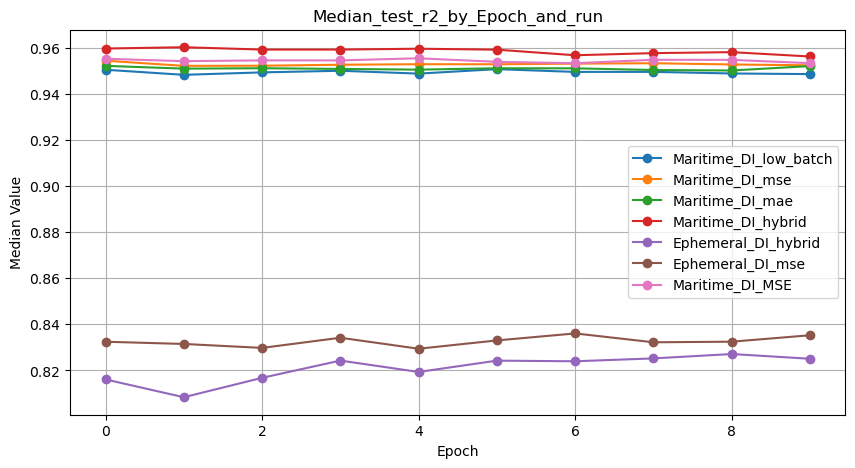

In [20]:
metrics = ["kge", "mse", "mae", "r2"]
for metric in metrics: 
    metric_name = f"test_{metric}"
    plot_median_comparison_2(dict_all, metric_name)

# Step 5B - Separate By Snow Type 

In [21]:
maritime_dict = {k: v for k, v in dict_all.items() if v.get('snow_type') == "Maritime"}
ephemeral_dict = {k: v for k, v in dict_all.items() if v.get('snow_type') == "Ephemeral"}

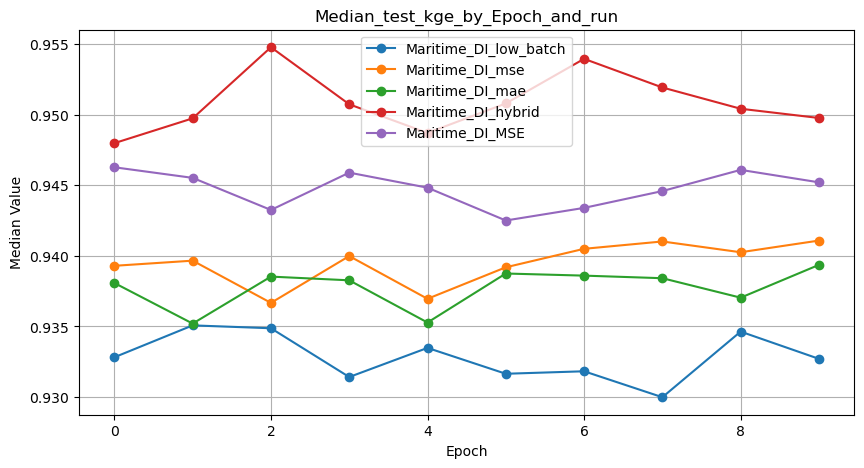

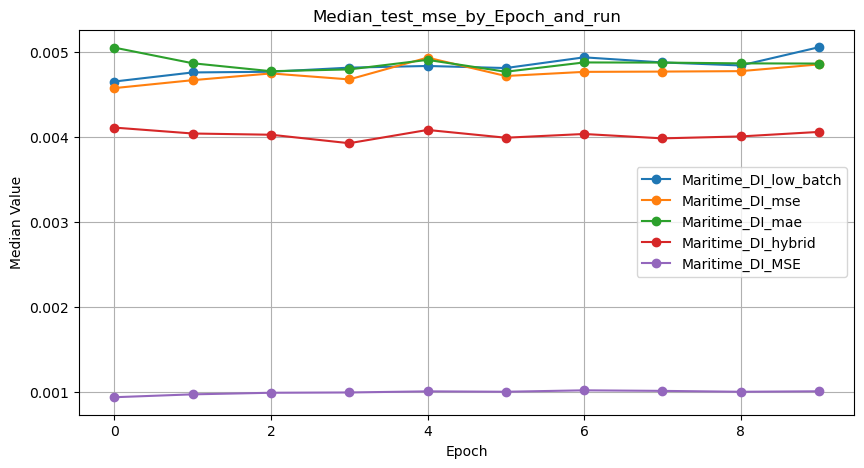

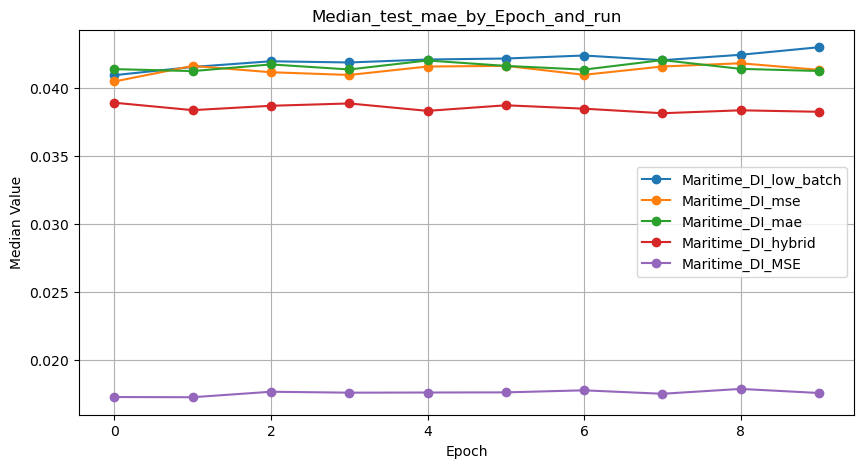

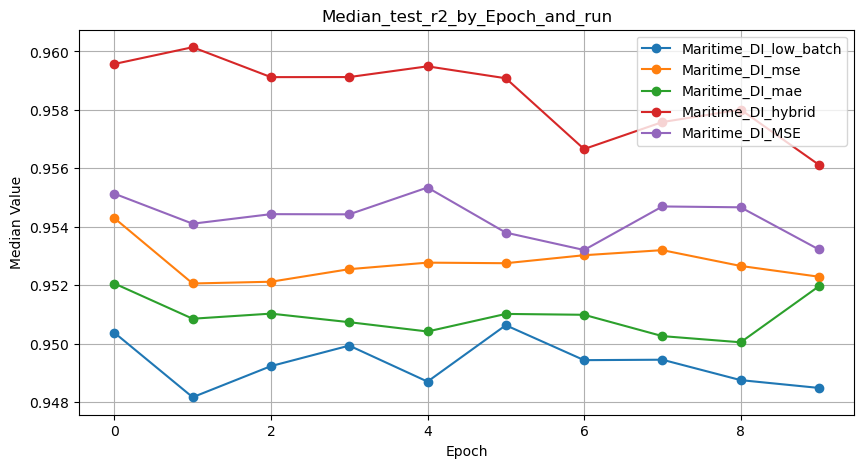

In [22]:
metrics = ["kge", "mse", "mae", "r2"]
for metric in metrics: 
    metric_name = f"test_{metric}"
    plot_median_comparison_2(maritime_dict, metric_name)

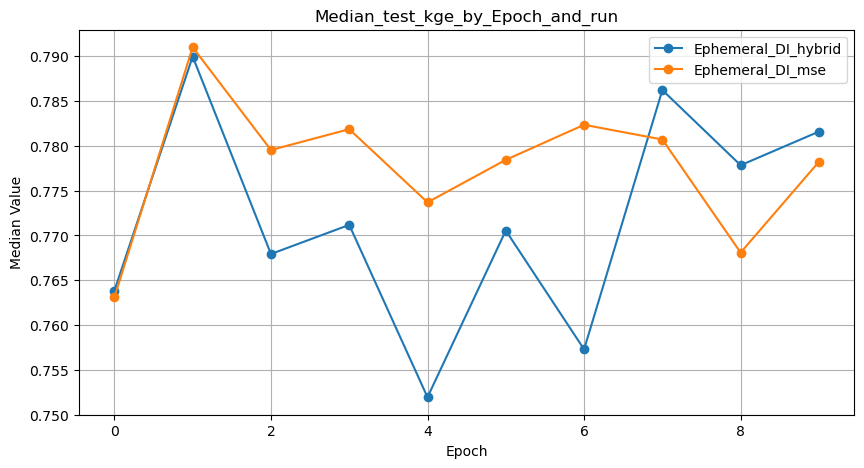

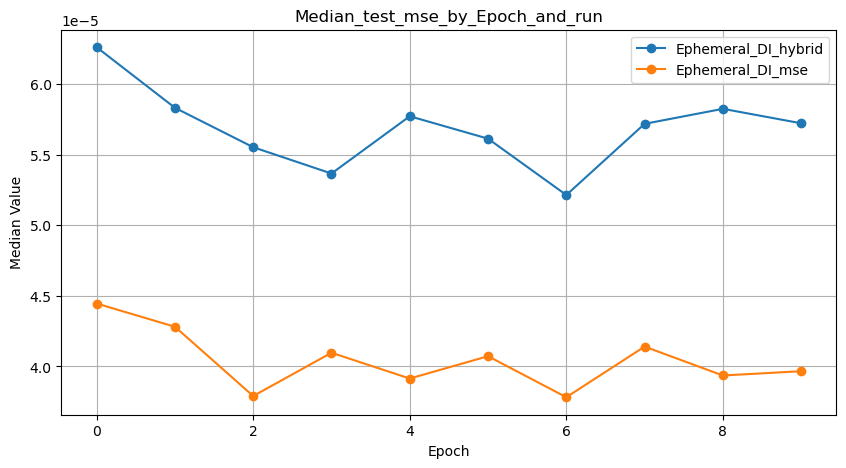

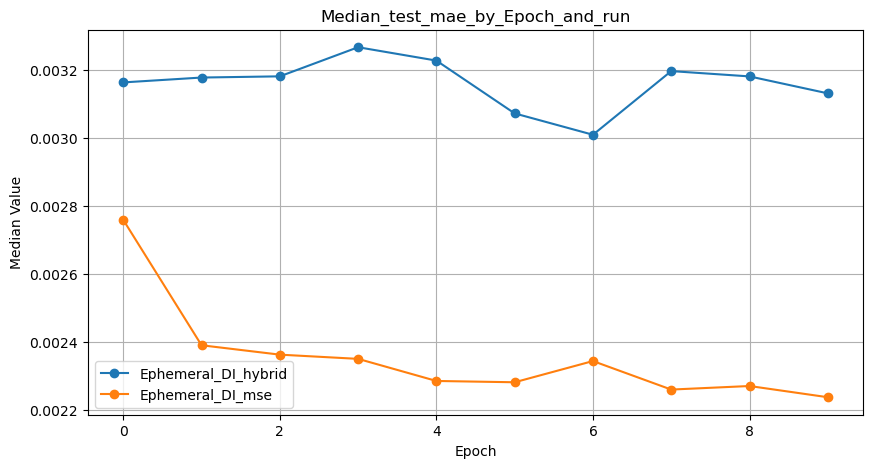

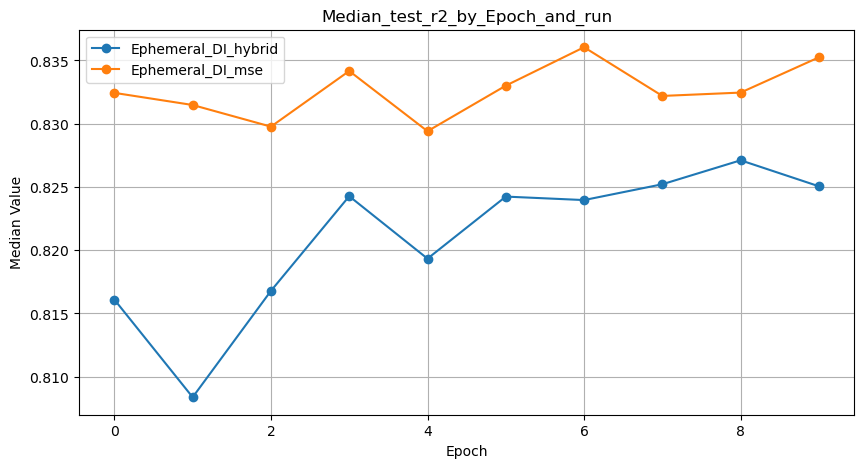

In [23]:
metrics = ["kge", "mse", "mae", "r2"]
for metric in metrics: 
    metric_name = f"test_{metric}"
    plot_median_comparison_2(ephemeral_dict, metric_name)

# Step 6 - Box Plots 